In [190]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import warnings
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import gridspec
import datetime
import seaborn as sns
import cmocean as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.stats import linregress
import matplotlib.patches as mpatches
import scipy.io as sio
import matplotlib.colors as mcolors
import matplotlib.patches as patch

from proj_utils import *
from mapping_utils import *

In [191]:
user_home_dir = expanduser('~')
fig_path      = user_home_dir + '/proj_folder/figures/'

In [192]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True)
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native')

In [194]:
#np.sort(list(mzz_local_directory.glob('*json')))

In [34]:
mzz_local_file= mzz_local_directory / 'OCEAN_VELOCITY_mon_mean_latlon_llc090_ECCOV4r5.json' # Pull monthly velocity 

In [35]:
fs = fsspec.filesystem("reference",     
                       fo=str(mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
# 
fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
ds = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

In [37]:
lon_mg, lat_mg  = np.meshgrid(ds.longitude, ds.latitude)

In [163]:
ds_mean = ds.mean(dim = 'time').compute()

In [164]:
### --- Open Bathy ---
bathy_path = user_home_dir + '/efs_ecco/ECCO/V4/r5/netcdf/latlon/geometry/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc'
ds_bathy   = xr.open_dataset(bathy_path).Depth

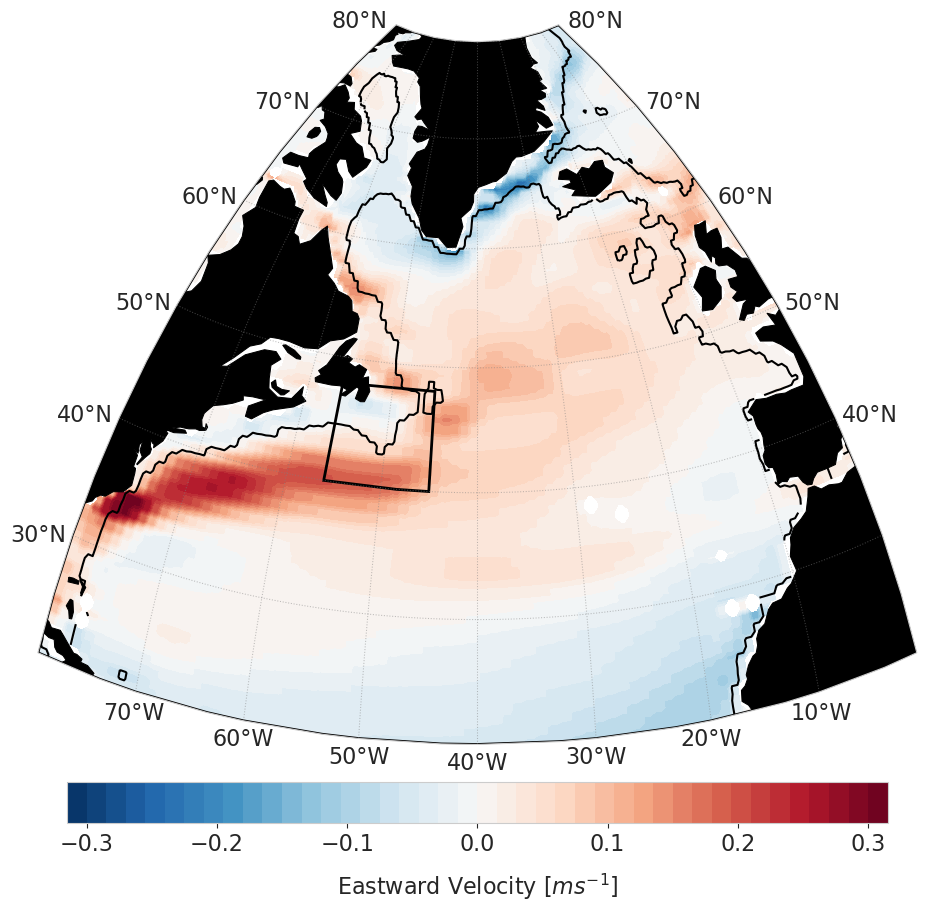

In [177]:
save_name    = 'surface_velocity_test'

plt_var      = ds_mean.EVEL[0,:,:]
max_val      = 0.3
plt_var.data[plt_var.data > max_val] = max_val
plt_var.data[plt_var.data < -max_val] = -max_val

bbox          = [-80,0,20,80] # Plotting Extent
plot_this_box = [-80,0,0,60]    # Locator box indicating a region
proj          = ccrs.PlateCarree() # Need to add this to most things as "transform=proj"
fig,ax,_      = init_orthomap(1,1,bbox)

# Add Coasts/Continent
ax     = add_coast_grid(ax,bbox,fill_color='k',line_color='k')
levels = np.linspace(-max_val,max_val,61)

# Plot contours
colorplot = ax.contourf(lon_mg,lat_mg,plt_var,transform=proj, levels=50, cmap='RdBu_r', zorder=0)
cbar = plt.colorbar(colorplot, fraction=0.057, pad=0.01, orientation='horizontal',ticks=np.linspace(-max_val,max_val, 7))
cbar.set_label('Eastward Velocity [$ms^{-1}$]', size='16', labelpad=11)

plt.contour(ds_bathy.longitude,ds_bathy.latitude,ds_bathy,levels = [1000],colors='k',transform = proj)
#plt.scatter(vels_N.longitude,np.repeat(vels_N.latitude,len(vels_N.longitude)),transform = proj)
cbar.ax.tick_params(labelsize=16)
ax.add_patch(patch.Rectangle((-56,40),11,8,facecolor='None',edgecolor='k',linewidth=2,transform=proj))
#plt.savefig(fig_path  + save_name + '.png', format='png', bbox_inches="tight",dpi=100)

In [175]:
### --- Define TGB BOX --- 
# Min Latitude = 40N; Max Latitude = 47N
# Min Longitude = 55(305)W; Max Longitude = 45(315)W

### -- Extract Velocity Across Northern and Western Boundaries ---
ds_box = ds_mean.sel(latitude = slice(39.75,48.25),longitude = slice(-56.25,-42.75))
vels_N = ds_box.sel(latitude = slice(47.5,48))
vels_W = ds_box.sel(longitude = slice(-56.25,-56))

(-500.0, 0.0)

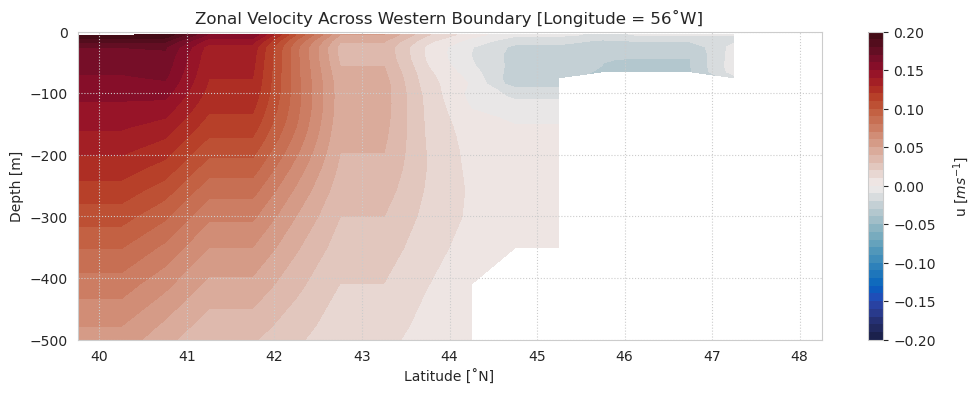

In [197]:
sns.set_style('whitegrid',{"grid.linestyle": ":"})
plt.figure(figsize=[12,4])
levels = np.linspace(-0.2,0.2,41)
plt.contourf(vels_W.latitude,vels_W.Z,vels_W.EVEL.squeeze(),cmap='cmo.balance',levels = levels,zorder = 0)
plt.title('Zonal Velocity Across Western Boundary [Longitude = 56˚W]')
cbar = plt.colorbar()
cbar.set_label('u [$ms^{-1}$]',  labelpad=11)
plt.xlabel('Latitude [˚N]')
plt.ylabel('Depth [m]')
plt.ylim([-500, 0])

(-500.0, 0.0)

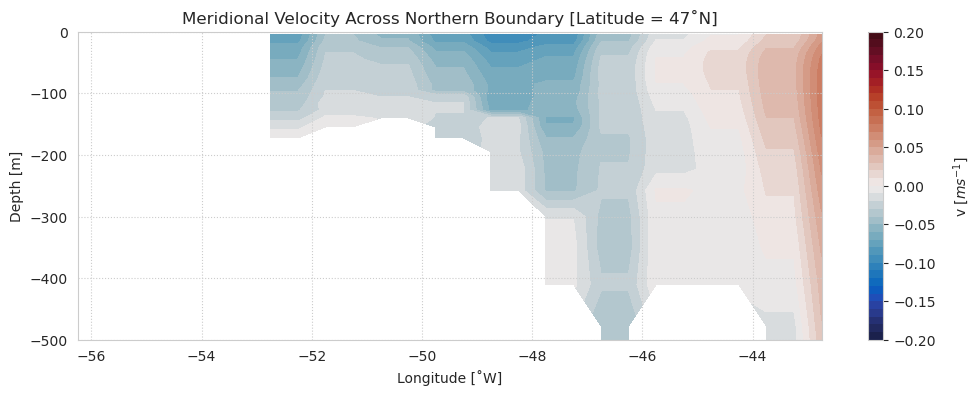

In [198]:
sns.set_style('whitegrid',{"grid.linestyle": ":"})
plt.figure(figsize=[12,4])
levels = np.linspace(-0.2,0.2,41)
plt.contourf(vels_N.longitude,vels_N.Z,vels_N.NVEL.squeeze(),cmap='cmo.balance',levels = levels,zorder = 0)
plt.title('Meridional Velocity Across Northern Boundary [Latitude = 47˚N]')
cbar = plt.colorbar()
cbar.set_label('v [$ms^{-1}$]',  labelpad=11)

plt.xlabel('Longitude [˚W]')
plt.ylabel('Depth [m]')
plt.ylim([-500, 0])